In [2]:
import pandas as pd
import os

# --- Configuration ---
# The name of your input file
input_filename = 'AAPL.csv'

# The name for the new output file
output_filename = 'AAPL_filtered.csv'

# The date from which you want to keep the data
start_date = '2010-10-11'

# The name of the date column in your CSV
date_column_name = 'AAPL.date'
# -------------------

def filter_data_by_date(input_file, output_file, date_col, start_dt):
    """
    Loads a CSV file, filters it to include data from a specific start date,
    and saves the result to a new CSV file.
    """
    # Check if the input file exists
    if not os.path.exists(input_file):
        print(f"Error: The file '{input_file}' was not found in this directory.")
        print("Please make sure the script and the CSV file are in the same folder.")
        return

    print(f"Loading data from '{input_file}'...")
    # Load the dataset into a pandas DataFrame
    df = pd.read_csv(input_file)

    print(f"Converting the date column '{date_col}' to a proper date format...")
    # Convert the date column to datetime objects for accurate filtering
    df[date_col] = pd.to_datetime(df[date_col])

    print(f"Filtering the data to include dates on or after {start_dt}...")
    # Perform the date filtering
    df_filtered = df[df[date_col] >= start_dt].copy()

    if df_filtered.empty:
        print("Warning: The filtered dataframe is empty. No data found on or after the specified start date.")
    else:
        print(f"Successfully filtered the data. Found {len(df_filtered)} rows.")
        # Save the filtered dataframe to a new CSV file, without the pandas index column
        df_filtered.to_csv(output_file, index=False)
        print(f"Filtered data has been saved to '{output_file}'.")

        # Display the first few rows of the new dataframe to confirm
        print("\n--- First 5 rows of the filtered data ---")
        print(df_filtered.head())
        print("\n--- Last 5 rows of the filtered data ---")
        print(df_filtered.tail())

if __name__ == '__main__':
    filter_data_by_date(
        input_file=input_filename,
        output_file=output_filename,
        date_col=date_column_name,
        start_dt=start_date
    )

Loading data from 'AAPL.csv'...
Converting the date column 'AAPL.date' to a proper date format...
Filtering the data to include dates on or after 2010-10-11...
Successfully filtered the data. Found 3605 rows.
Filtered data has been saved to 'AAPL_filtered.csv'.

--- First 5 rows of the filtered data ---
      AAPL.date  AAPL.price  AAPL.return  AAPL.growth_rate  \
1686 2010-10-11       10.55     0.475060          0.476190   
1687 2010-10-12       10.66     1.037256          1.042654   
1688 2010-10-13       10.72     0.561274          0.562852   
1689 2010-10-14       10.80     0.743498          0.746269   
1690 2010-10-15       11.24     3.993271          4.074074   

      AAPL.RV_SquareReturn AAPL_RV.5min.date  AAPL_RV.5min  \
1686              0.225682        2010/10/11      0.598871   
1687              1.075900        2010/10/12      1.478056   
1688              0.315028        2010/10/13      0.701093   
1689              0.552789        2010/10/14      0.517500   
1690        

1. 正在从 'AAPL_filtered.csv' 加载AAPL数据...
数据清理完成，剩余 3605 条有效记录用于分析。

==================== 开始处理: MF-DFA for Delta Alpha ====================
正在为AAPL计算MF-DFA Delta Alpha (T=252). 此过程可能需要几分钟...
  ... processing window 100 / 3354
  ... processing window 200 / 3354
  ... processing window 300 / 3354
  ... processing window 400 / 3354
  ... processing window 500 / 3354
  ... processing window 600 / 3354
  ... processing window 700 / 3354
  ... processing window 800 / 3354
  ... processing window 900 / 3354
  ... processing window 1000 / 3354
  ... processing window 1100 / 3354
  ... processing window 1200 / 3354
  ... processing window 1300 / 3354
  ... processing window 1400 / 3354
  ... processing window 1500 / 3354
  ... processing window 1600 / 3354
  ... processing window 1700 / 3354
  ... processing window 1800 / 3354
  ... processing window 1900 / 3354
  ... processing window 2000 / 3354
  ... processing window 2100 / 3354
  ... processing window 2200 / 3354
  ... processing window 2300 

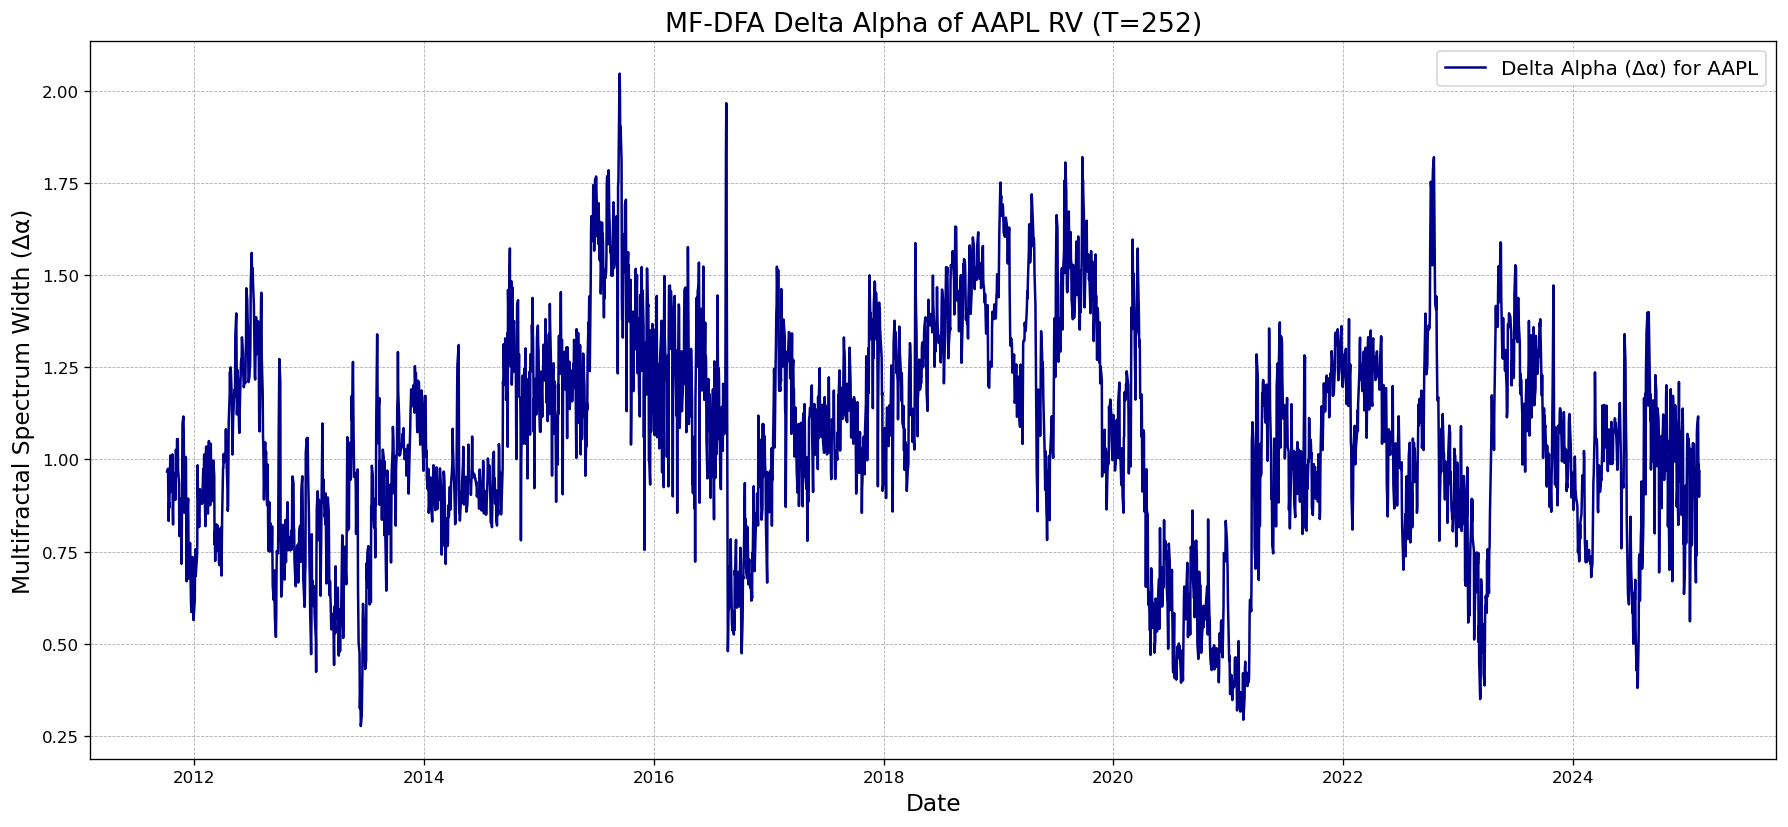

In [3]:
# =============================================================================
# 栏目 0: 全局设置与导入
# =============================================================================
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import datetime
import warnings

warnings.filterwarnings("ignore")

#################################################################
# Part 1: MF-DFA 核心算法函数
#################################################################
def mfdfa_core(series, lag, q, order):
    """
    从零实现的MF-DFA核心算法。
    """
    Y = np.cumsum(series - np.mean(series))
    N = len(Y)
    F_q = np.zeros((len(lag), len(q)))
    
    for i, s in enumerate(lag):
        segments = N // s
        RMS = []
        for v in range(segments):
            start, end = v * s, (v + 1) * s
            segment = Y[start:end]
            x_ax = np.arange(s)
            try:
                coeffs = np.polyfit(x_ax, segment, order)
                trend = np.polyval(coeffs, x_ax)
                RMS.append(np.sqrt(np.mean((segment - trend)**2)))
            except np.linalg.LinAlgError:
                continue
        
        if not RMS:
            continue
            
        RMS = np.array(RMS)
        
        for j, q_val in enumerate(q):
            if q_val == 0:
                F_q[i, j] = np.exp(0.5 * np.mean(np.log(RMS**2)))
            else:
                F_q[i, j] = np.mean(RMS**q_val)**(1/q_val)

    h = np.zeros(len(q))
    for i, q_val in enumerate(q):
        valid = F_q[:, i] > 0
        if np.sum(valid) > 1:
            log_lag = np.log(lag[valid])
            log_F_q = np.log(F_q[valid, i])
            h[i] = np.polyfit(log_lag, log_F_q, 1)[0]
    
    return h

def calculate_delta_alpha(series, q_range, order):
    """
    调用mfdfa_core, 并完成后续计算得到 Delta Alpha
    """
    q = np.linspace(q_range[0], q_range[1], int(q_range[2]))
    min_lag = max(10, order + 1)
    max_lag = len(series) // 4
    if max_lag <= min_lag: return np.nan
    lag = np.unique(np.logspace(np.log10(min_lag), np.log10(max_lag), 25).astype(int))
    
    if len(lag) < 2: return np.nan
        
    try:
        h_q = mfdfa_core(series, lag=lag, q=q, order=order)
        tau_q = h_q * q - 1
        alpha = np.gradient(tau_q, q)
        delta_alpha = np.max(alpha) - np.min(alpha)
        return delta_alpha
    except Exception:
        return np.nan

def MFDFA_Delta_Alpha_from_scratch(X, T=252, step=1):
    """
    滑动窗口函数
    """
    X, nX = np.array(X), X.shape[0]
    if nX < T:
        print(f"警告: 数据长度 ({nX}) 小于窗口大小 T ({T})。")
        return np.array([])
        
    num_results = (nX - T) // step + 1
    delta_alphas = np.full(num_results, np.nan)
    
    q_range = (-5, 5, 101)
    detrending_order = 1
    
    desc_text = f"正在为AAPL计算MF-DFA Delta Alpha (T={T}). 此过程可能需要几分钟..."
    print(desc_text)
    
    for i in range(num_results):
        # Manually print progress every 100 steps
        if (i + 1) % 100 == 0:
            print(f"  ... processing window {i+1} / {num_results}")
        idx = i * step
        XX = X[idx:idx+T]
        if not np.all(np.isfinite(XX)): continue
        da = calculate_delta_alpha(XX, q_range, detrending_order)
        delta_alphas[i] = da
        
    return delta_alphas

#################################################################
# Part 2: 主执行程序
#################################################################
if __name__ == "__main__":
    
    # --- 2.1: 参数配置 ---
    FILENAME = 'AAPL_filtered.csv' 
    CSV_DATE_COL = 'AAPL.date'
    CSV_RETURN_COL = 'AAPL.return'
    CSV_RV_COL = 'AAPL_RV.5min'
    TARGET_WINDOW_SIZE = 252
    STEP = 1

    # --- 2.2: 数据加载与序列构建 ---
    print(f"1. 正在从 '{FILENAME}' 加载AAPL数据...")
    if not os.path.exists(FILENAME):
        raise FileNotFoundError(f"错误: 文件 '{FILENAME}' 未找到。请确保脚本和CSV文件在同一个文件夹中。")
    
    data = pd.read_csv(FILENAME)
    data[CSV_DATE_COL] = pd.to_datetime(data[CSV_DATE_COL])
    
    required_cols = [CSV_DATE_COL, CSV_RETURN_COL, CSV_RV_COL]
    if not all(col in data.columns for col in required_cols):
        missing = [col for col in required_cols if col not in data.columns]
        raise ValueError(f"错误: CSV文件缺少必要的列。需要: {required_cols}, 缺失: {missing}")

    data.sort_values(by=CSV_DATE_COL, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    analysis_df = data[required_cols].copy()
    analysis_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    analysis_df.dropna(inplace=True)

    print(f"数据清理完成，剩余 {len(analysis_df)} 条有效记录用于分析。")
    
    target_series = analysis_df[CSV_RV_COL].values

    # --- 2.3: 执行 MF-DFA 计算 ---
    print(f"\n{'='*20} 开始处理: MF-DFA for Delta Alpha {'='*20}")
    
    delta_alpha_series = MFDFA_Delta_Alpha_from_scratch(
        target_series, 
        T=TARGET_WINDOW_SIZE, 
        step=STEP
    )

    if len(delta_alpha_series) > 0:
        # --- 2.4: 合并数据并保存 ---
        print("\n3. 正在对齐日期并合并所有特征...")
        
        aligned_df = analysis_df.iloc[TARGET_WINDOW_SIZE - 1:].reset_index(drop=True)

        if len(delta_alpha_series) < len(aligned_df):
            aligned_df = aligned_df.iloc[:len(delta_alpha_series)]
            
        final_df = pd.DataFrame({
            'date': aligned_df[CSV_DATE_COL],
            'rt': aligned_df[CSV_RETURN_COL],
            'RV': aligned_df[CSV_RV_COL],
            'delta_alpha_T252': delta_alpha_series
        })
        
        output_filename = 'AAPL_MFDFA_Features.csv'
        final_df.to_csv(output_filename, index=False, float_format='%.6f')

        print(f"\n4. 所有特征已成功整合并保存到文件: {output_filename}")

        # 绘制结果图
        plt.figure(figsize=(15, 7), dpi=120)
        plt.plot(final_df['date'], final_df['delta_alpha_T252'], color='darkblue', label='Delta Alpha (Δα) for AAPL', linewidth=1.5)
        plt.title(f'MF-DFA Delta Alpha of AAPL RV (T={TARGET_WINDOW_SIZE})', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Multifractal Spectrum Width (Δα)', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        
        plot_filename = 'AAPL_MFDFA_Delta_Alpha.png'
        plt.savefig(plot_filename)
        print(f"绘制的图表已保存为: {plot_filename}")
        
        # 显示图像
        plt.show()
    else:
        print("\nMF-DFA 没有计算出任何结果。")

1. 正在从 'AAPL_filtered.csv' 加载AAPL数据...
数据清理完成，剩余 3605 条有效记录用于分析。

==================== 开始处理: OSW-MF-DFA for Delta Alpha ====================


正在为AAPL计算OSW-MF-DFA Delta Alpha (T=252): 100%|██████████| 3354/3354 [02:47<00:00, 20.05it/s]



3. 正在对齐日期并合并所有特征...

4. 所有特征已成功整合并保存到文件: AAPL_OSW_MFDFA_Features.csv
绘制的图表已保存为: AAPL_OSW_MFDFA_Delta_Alpha.png


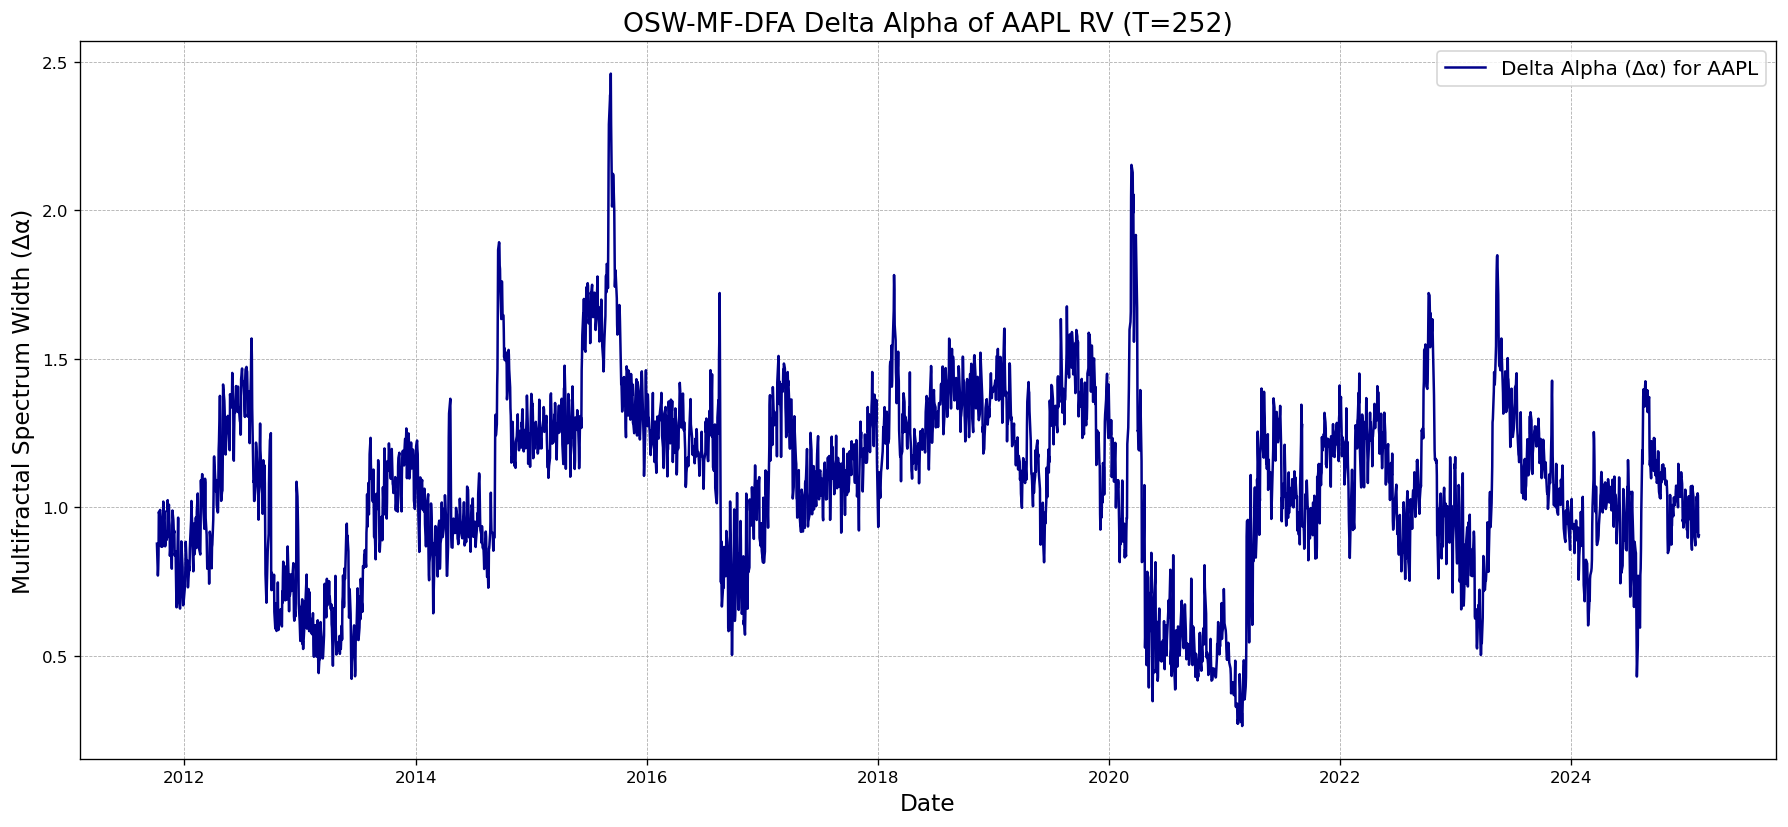

In [8]:
# =============================================================================
# 栏目 0: 全局设置与导入
# =============================================================================
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import datetime
from tqdm import trange # 引入tqdm库用于显示进度条
import warnings

warnings.filterwarnings("ignore")

#################################################################
# Part 1: OSW-MF-DFA 核心算法函数 (已升级)
#################################################################

def mfdfa_core_osw(series, lag, q, order, overlap_ratio=1/3):
    """
    从零实现的 OSW-MF-DFA (Overlapped Sliding Window) 核心算法。
    相比标准 MF-DFA，此版本使用重叠窗口以获得更稳定的结果。
    """
    # 1. 计算序列的 profile (累积和)
    Y = np.cumsum(series - np.mean(series))
    N = len(Y)
    
    # 2. 初始化 q 阶波动函数 F_q(s)
    F_q = np.zeros((len(lag), len(q)))
    
    # 3. 对每个尺度 s (lag)进行计算
    for i, s in enumerate(lag):
        # --- [核心修改点：从不重叠变为重叠滑动窗口] ---
        overlap = int(s * overlap_ratio)
        step = s - overlap
        if step <= 0:  # 确保步长为正
            continue
        
        # 计算滑动窗口产生的总段数
        num_segments = (N - s) // step + 1
        RMS = []
        for v in range(num_segments):
            start = v * step
            end = start + s
            # 确保最后一个窗口不会超出序列边界
            if end > N:
                break
            
            segment = Y[start:end]
        # --- [修改结束] ---
            
            # 5. 对每个段进行多项式拟合去趋势
            x_ax = np.arange(s)
            try:
                coeffs = np.polyfit(x_ax, segment, order)
                trend = np.polyval(coeffs, x_ax)
                # 6. 计算去趋势后的均方根误差 (波动)
                RMS.append(np.sqrt(np.mean((segment - trend)**2)))
            except np.linalg.LinAlgError:
                continue
        
        if not RMS:
            continue
            
        RMS = np.array(RMS)
        
        # 7. 计算 q 阶波动函数 F_q(s)
        for j, q_val in enumerate(q):
            # 排除RMS中的零值，避免在log计算中出错
            valid_rms = RMS[RMS > 0]
            if len(valid_rms) == 0:
                F_q[i, j] = 0
                continue
            
            if q_val == 0:
                F_q[i, j] = np.exp(0.5 * np.mean(np.log(valid_rms**2)))
            else:
                F_q[i, j] = np.mean(valid_rms**q_val)**(1/q_val)

    # 8. 通过对数-对数图的斜率计算 h(q)
    h = np.zeros(len(q))
    for i, q_val in enumerate(q):
        valid = F_q[:, i] > 0
        if np.sum(valid) > 1: # 至少需要两个点才能拟合一条直线
            log_lag = np.log(lag[valid])
            log_F_q = np.log(F_q[valid, i])
            h[i] = np.polyfit(log_lag, log_F_q, 1)[0]
    
    return h

def calculate_delta_alpha(series, q_range, order):
    """
    调用 mfdfa_core_osw, 并完成后续计算得到 Delta Alpha
    """
    q = np.linspace(q_range[0], q_range[1], int(q_range[2]))
    # 优化lag的选取，确保尺度足够大且数量适中
    min_lag = max(10, order + 2) # 最小尺度必须大于多项式阶数
    max_lag = len(series) // 4
    if min_lag >= max_lag:
        return np.nan
        
    lag = np.unique(np.logspace(np.log10(min_lag), np.log10(max_lag), 25).astype(int))
    if len(lag) < 2: return np.nan
        
    try:
        # 调用新的 OSW-MF-DFA 核心函数
        h_q = mfdfa_core_osw(series, lag=lag, q=q, order=order, overlap_ratio=1/3)
        # 检查h_q中是否包含NaN或inf
        if not np.all(np.isfinite(h_q)):
            return np.nan
            
        tau_q = h_q * q - 1
        alpha = np.gradient(tau_q, q)
        delta_alpha = np.max(alpha) - np.min(alpha)
        return delta_alpha
    except Exception:
        return np.nan

def MFDFA_Delta_Alpha_from_scratch(X, T=252, step=1):
    """
    滑动窗口函数，调用新的 OSW-MF-DFA 核心算法
    """
    X, nX = np.array(X), X.shape[0]
    if nX < T:
        print(f"警告: 数据长度 ({nX}) 小于窗口大小 T ({T})。")
        return np.array([])
        
    num_results = (nX - T) // step + 1
    delta_alphas = np.full(num_results, np.nan)
    
    q_range = (-5, 5, 101)
    detrending_order = 1
    
    desc_text = f"正在为AAPL计算OSW-MF-DFA Delta Alpha (T={T})"
    
    # 使用tqdm来显示进度条，替代手动打印
    for i in trange(num_results, desc=desc_text):
        idx = i * step
        XX = X[idx:idx+T]
        if not np.all(np.isfinite(XX)): continue
        da = calculate_delta_alpha(XX, q_range, detrending_order)
        delta_alphas[i] = da
        
    return delta_alphas

#################################################################
# Part 2: 主执行程序 (已适配 OSW-MF-DFA)
#################################################################
if __name__ == "__main__":
    
    # --- 2.1: 参数配置 ---
    FILENAME = 'AAPL_filtered.csv' 
    CSV_DATE_COL = 'AAPL.date'
    CSV_RETURN_COL = 'AAPL.return'
    CSV_RV_COL = 'AAPL_RV.5min'
    TARGET_WINDOW_SIZE = 252
    STEP = 1

    # --- 2.2: 数据加载与序列构建 ---
    print(f"1. 正在从 '{FILENAME}' 加载AAPL数据...")
    if not os.path.exists(FILENAME):
        raise FileNotFoundError(f"错误: 文件 '{FILENAME}' 未找到。请确保脚本和CSV文件在同一个文件夹中。")
    
    data = pd.read_csv(FILENAME)
    data[CSV_DATE_COL] = pd.to_datetime(data[CSV_DATE_COL])
    
    required_cols = [CSV_DATE_COL, CSV_RETURN_COL, CSV_RV_COL]
    if not all(col in data.columns for col in required_cols):
        missing = [col for col in required_cols if col not in data.columns]
        raise ValueError(f"错误: CSV文件缺少必要的列。需要: {required_cols}, 缺失: {missing}")

    data.sort_values(by=CSV_DATE_COL, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    analysis_df = data[required_cols].copy()
    analysis_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    analysis_df.dropna(inplace=True)

    print(f"数据清理完成，剩余 {len(analysis_df)} 条有效记录用于分析。")
    
    target_series = analysis_df[CSV_RV_COL].values

    # --- 2.3: 执行 OSW-MF-DFA 计算 ---
    print(f"\n{'='*20} 开始处理: OSW-MF-DFA for Delta Alpha {'='*20}")
    
    delta_alpha_series = MFDFA_Delta_Alpha_from_scratch(
        target_series, 
        T=TARGET_WINDOW_SIZE, 
        step=STEP
    )

    if len(delta_alpha_series) > 0 and not np.all(np.isnan(delta_alpha_series)):
        # --- 2.4: 合并数据并保存 ---
        print("\n3. 正在对齐日期并合并所有特征...")
        
        # 对齐日期，使delta_alpha序列的第一个值对应第T个数据点
        aligned_df = analysis_df.iloc[TARGET_WINDOW_SIZE - 1:].reset_index(drop=True)

        # 确保delta_alpha序列和对齐后的DataFrame长度一致
        min_len = min(len(delta_alpha_series), len(aligned_df))
        aligned_df = aligned_df.iloc[:min_len]
        delta_alpha_series = delta_alpha_series[:min_len]
            
        final_df = pd.DataFrame({
            'date': aligned_df[CSV_DATE_COL],
            'rt': aligned_df[CSV_RETURN_COL],
            'RV': aligned_df[CSV_RV_COL],
            'delta_alpha_T252': delta_alpha_series
        })
        
        # 移除计算结果为NaN的行
        final_df.dropna(subset=['delta_alpha_T252'], inplace=True)
        
        # 更新输出文件名以反映新方法
        output_filename = 'AAPL_OSW_MFDFA_Features.csv'
        final_df.to_csv(output_filename, index=False, float_format='%.6f')

        print(f"\n4. 所有特征已成功整合并保存到文件: {output_filename}")

        # 绘制结果图
        plt.figure(figsize=(15, 7), dpi=120)
        plt.plot(final_df['date'], final_df['delta_alpha_T252'], color='darkblue', label='Delta Alpha (Δα) for AAPL', linewidth=1.5)
        # 更新图表标题以反映新方法
        plt.title(f'OSW-MF-DFA Delta Alpha of AAPL RV (T={TARGET_WINDOW_SIZE})', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Multifractal Spectrum Width (Δα)', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        
        # 更新图表保存文件名
        plot_filename = 'AAPL_OSW_MFDFA_Delta_Alpha.png'
        plt.savefig(plot_filename)
        print(f"绘制的图表已保存为: {plot_filename}")
        
        # 显示图像
        plt.show()
    else:
        print("\nOSW-MF-DFA 没有计算出任何有效结果。")

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('AAPL_OSW_MFDFA_Features.csv')

# 绘制 rt 图表
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df['date']), df['rt'])
plt.title('AAPL rt Over Time')
plt.xlabel('Date')
plt.ylabel('rt')
plt.grid(True)
plt.savefig('aapl_rt_plot.png')
plt.close()

# 绘制 RV 图表
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df['date']), df['RV'])
plt.title('AAPL RV Over Time')
plt.xlabel('Date')
plt.ylabel('RV')
plt.grid(True)
plt.savefig('aapl_RV_plot.png')
plt.close()

# 绘制 delta_alpha_T252 图表
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df['date']), df['delta_alpha_T252'])
plt.title('AAPL delta_alpha_T252 Over Time')
plt.xlabel('Date')
plt.ylabel('delta_alpha_T252')
plt.grid(True)
plt.savefig('aapl_delta_alpha_T252_plot.png')
plt.close()

print("AAPL 数据集的图表已成功创建。")

AAPL 数据集的图表已成功创建。


In [11]:
import pandas as pd
from scipy.stats import skew, kurtosis, jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch

def run_all_tests_for_columns(df, columns, dataset_name):
    """
    对DataFrame中指定的所有列运行统计检验。
    """
    for col in columns:
        print(f"\n--- 正在对 {dataset_name} 数据集的 '{col}' 列进行检验 ---")
        data = df[col].dropna()

        # 1. 基础统计量
        desc_stats = {
            '均值 (Mean)': data.mean(),
            '标准差 (Std. Dev.)': data.std(),
            '最大值 (Max)': data.max(),
            '最小值 (Min)': data.min()
        }
        print("\n1. 基础统计量:")
        print(pd.Series(desc_stats))

        # 2. 正态性检验
        jb_test = jarque_bera(data)
        norm_test = {
            '偏度 (Skewness)': skew(data),
            '峰度 (Kurtosis)': kurtosis(data),
            'Jarque-Bera 统计量': jb_test[0],
            'JB检验 p-value': jb_test[1]
        }
        print("\n2. 正态性检验:")
        print(pd.Series(norm_test))

        # 3. 平稳性检验
        try:
            adf_test = adfuller(data)
            kpss_test = kpss(data, regression='c', nlags="auto")
            stationarity_test = {
                'ADF 统计量': adf_test[0],
                'ADF检验 p-value': adf_test[1],
                'KPSS 统计量': kpss_test[0],
                'KPSS检验 p-value': kpss_test[1]
            }
            print("\n3. 平稳性检验:")
            print(pd.Series(stationarity_test))
        except Exception as e:
            print(f"\n3. 平稳性检验出错: {e}")


        # 4. ARCH效应检验
        try:
            arch_test = het_arch(data)
            arch_results = {
                'ARCH-LM 统计量': arch_test[0],
                'ARCH-LM检验 p-value': arch_test[1]
            }
            print("\n4. ARCH效应检验:")
            print(pd.Series(arch_results))
        except Exception as e:
            print(f"\n4. ARCH效应检验出错: {e}")

# 加载AAPL数据并运行检验
try:
    aapl_df = pd.read_csv('AAPL_OSW_MFDFA_Features.csv')
    columns_to_test = ['rt', 'RV', 'delta_alpha_T252']
    run_all_tests_for_columns(aapl_df, columns_to_test, 'AAPL')
except FileNotFoundError:
    print("\nAAPL 数据集 (AAPL_OSW_MFDFA_Features.csv) 未找到。")


--- 正在对 AAPL 数据集的 'rt' 列进行检验 ---

1. 基础统计量:
均值 (Mean)           0.084273
标准差 (Std. Dev.)     1.773152
最大值 (Max)          11.308120
最小值 (Min)         -13.771339
dtype: float64

2. 正态性检验:
偏度 (Skewness)        -0.251472
峰度 (Kurtosis)         5.712629
Jarque-Bera 统计量    4595.969334
JB检验 p-value          0.000000
dtype: float64


C:\Users\18319\AppData\Local\Temp\ipykernel_66524\977646515.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data, regression='c', nlags="auto")



3. 平稳性检验:
ADF 统计量          -1.861662e+01
ADF检验 p-value     2.062955e-30
KPSS 统计量          4.816619e-02
KPSS检验 p-value    1.000000e-01
dtype: float64

4. ARCH效应检验:
ARCH-LM 统计量          3.672920e+02
ARCH-LM检验 p-value    8.487473e-73
dtype: float64

--- 正在对 AAPL 数据集的 'RV' 列进行检验 ---

1. 基础统计量:
均值 (Mean)           1.713518
标准差 (Std. Dev.)     2.752565
最大值 (Max)          49.150337
最小值 (Min)           0.085581
dtype: float64

2. 正态性检验:
偏度 (Skewness)      9.417596e+00
峰度 (Kurtosis)      1.262427e+02
Jarque-Bera 统计量    2.276806e+06
JB检验 p-value       0.000000e+00
dtype: float64

3. 平稳性检验:
ADF 统计量          -9.975038e+00
ADF检验 p-value     2.188966e-17
KPSS 统计量          4.247218e-01
KPSS检验 p-value    6.649921e-02
dtype: float64

4. ARCH效应检验:
ARCH-LM 统计量           7.832994e+02
ARCH-LM检验 p-value    8.026339e-162
dtype: float64

--- 正在对 AAPL 数据集的 'delta_alpha_T252' 列进行检验 ---

1. 基础统计量:
均值 (Mean)          1.083995
标准差 (Std. Dev.)    0.301360
最大值 (Max)          2.459393
最小值 (Min)          0.263144
dty

In [6]:
# =============================================================================
# 栏目 0: 全局设置与导入
# =============================================================================
import random
import numpy as np
import torch
import os
import pandas as pd
import time as tm
import datetime
import math
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"全局随机种子已设置为: {seed}")


# =============================================================================
# 栏目 1: 全局配置文件 (已适配AAPL数据集和终极模型)
# =============================================================================
time_str = datetime.date.today().isoformat()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

cfg = {
    "files": {
        # --- 已修改为使用AAPL数据集 ---
        'main_data_source': 'AAPL_MFDFA_Features.csv',
    },
    "experiments": {
        "MF_FCOC_LSTM_VaR_AAPL_RUN": {
            "model_to_run": "MF_FCOC_LSTM",
            # 确保 'AAPL_MFDFA_Features.csv' 文件中包含这些列
            "feature_cols": ['rt', 'RV', 'delta_alpha_T252'],
            "oscillator_types_to_run": list(range(1, 11)),
            "lee_common_params": {
                "N_history": 100, "use_precomputation": True,
                "lookup_steps": 2000, "lookup_range": [-2.0, 2.0]
            }
        }
    },
    "data_common": {
        "train_split_size": 0.70, "val_split_size": (1/3), "target_col_name": 'rt',
        "time_step": 60 # 新增 time_step 参数
    },
    "training_common": {
        "device": device, "num_epoch": 100, "batch_size": 64,
        "var_alpha": 0.05, "tau": 0.05,
        "beta_firm_cost": 0.0001 # 为公司损失函数(FS)设置的资本成本
    },
    "model_params": {
        "common": {"num_layers": 1, "output_size": 1, "dropout": 0.2, "hidden_size": 128},
    },
    "results": {
        # --- 已修改输出目录和文件名 ---
        "output_dir": "Ultimate_Model_AAPL_Comprehensive_VaR_Results",
        "results_filename": f"MF_FCOC_LSTM_AAPL_Comprehensive_Results_{time_str}.csv",
    }
}


# =============================================================================
# 栏目 2: VaR核心组件 (已新增CC检验和损失函数)
# =============================================================================
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__(); self.quantiles = quantiles
    def forward(self, preds, target):
        assert not target.requires_grad; assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
        return torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))

def kupiec_uc_test(violations, alpha):
    num_violations = np.sum(violations); total_obs = len(violations)
    violation_rate = num_violations / total_obs
    if num_violations == 0 or num_violations == total_obs: return violation_rate, 0.0, 0.0
    epsilon = 1e-9; vr_clipped = max(epsilon, min(violation_rate, 1 - epsilon))
    log_likelihood_unrestricted = num_violations * np.log(vr_clipped) + (total_obs - num_violations) * np.log(1 - vr_clipped)
    log_likelihood_restricted = num_violations * np.log(alpha) + (total_obs - num_violations) * np.log(1 - alpha)
    lr_uc = -2 * (log_likelihood_restricted - log_likelihood_unrestricted)
    p_value_uc = 1 - chi2.cdf(lr_uc, 1)
    return violation_rate, p_value_uc, lr_uc

def christoffersen_cc_test(violations, alpha):
    violation_rate, p_value_uc, lr_uc = kupiec_uc_test(violations, alpha)
    if p_value_uc == 0.0: return violation_rate, p_value_uc, 0.0
    
    n00, n01, n10, n11 = 0, 0, 0, 0
    for i in range(1, len(violations)):
        if violations[i-1] == 0 and violations[i] == 0: n00 += 1
        elif violations[i-1] == 0 and violations[i] == 1: n01 += 1
        elif violations[i-1] == 1 and violations[i] == 0: n10 += 1
        elif violations[i-1] == 1 and violations[i] == 1: n11 += 1
        
    if (n00 + n01 == 0) or (n10 + n11 == 0): return violation_rate, p_value_uc, 0.0
    
    pi01 = n01 / (n00 + n01); pi11 = n11 / (n10 + n11); pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    if pi01 < 1e-9 or pi11 < 1e-9 or pi < 1e-9 or (1-pi01) < 1e-9 or (1-pi11) < 1e-9 or (1-pi) < 1e-9:
        return violation_rate, p_value_uc, 0.0
        
    log_likelihood_ind_unrestricted = n00 * np.log(1 - pi01) + n01 * np.log(pi01) + n10 * np.log(1 - pi11) + n11 * np.log(pi11)
    log_likelihood_ind_restricted = (n00 + n10) * np.log(1 - pi) + (n01 + n11) * np.log(pi)
    lr_ind = -2 * (log_likelihood_ind_restricted - log_likelihood_ind_unrestricted)
    
    lr_cc = lr_uc + lr_ind
    p_value_cc = 1 - chi2.cdf(lr_cc, 2)
    return violation_rate, p_value_uc, p_value_cc

def regulator_loss_rql(returns, var_preds):
    violations = returns < var_preds
    losses = np.where(violations, 1 + (var_preds - returns)**2, 0)
    return np.mean(losses)

def firm_loss_fs(returns, var_preds, beta):
    violations = returns < var_preds
    losses = np.where(violations, (var_preds - returns)**2, beta * -var_preds)
    return np.mean(losses)

# =============================================================================
# 栏目 3: Lee振荡器激活函数定义
# =============================================================================
LEE_OSCILLATOR_PARAMETERS = {
    1: (0.0, 5.0, 5.0, 1.0, 0.0, -1.0, 1.0, 0.0, True, 0.001, 500), 2: (0.5, 0.55, 0.55, -0.5, 0.5, -0.55, -0.55, -0.5, False, 0.001, 50),
    3: (0.5, 0.6, 0.55, 0.5, -0.5, -0.6, -0.55, 0.5, False, 0.001, 50), 4: (-0.5, 0.55, 0.55, -0.5, -0.5, -0.55, -0.55, 0.5, False, 0.001, 50),
    5: (-0.9, 0.9, 0.9, -0.9, 0.9, -0.9, -0.9, 0.9, False, 0.001, 50), 6: (-0.9, 0.9, 0.9, -0.9, 0.9, -0.9, -0.9, 0.9, False, 0.001, 300),
    7: (-5.0, 5.0, 5.0, -5.0, 1.0, -1.0, -1.0, 1.0, False, 0.001, 50), 8: (-5.0, 5.0, 5.0, -5.0, 1.0, -1.0, -1.0, 1.0, False, 0.001, 300),
    9: (1.0, -1.0, -1.0, -1.0, -1.0, 2.0, 2.0, -1.0, False, 0.001, 50), 10: (3.0, 3.0, 3.0, 2.0, 0.45, -0.45, -0.45, 1.0, False, 0.001, 50)
}

class OriginalLeeActivation(nn.Module):
    def __init__(self, activation_params):
        super().__init__(); self.N=activation_params['N_history']; self.osc_params=LEE_OSCILLATOR_PARAMETERS[activation_params['oscillator_type']]
    def forward(self, x):
        dev=x.device; B_flat_size=x.numel(); x_flat=x.view(B_flat_size, 1)
        a1,a2,a3,a4,b1,b2,b3,b4,is_t5,e,k=self.osc_params
        E,I,L,O=[torch.zeros(B_flat_size, 1, self.N, device=dev) for _ in range(4)]; E[:,:,0],L[:,:,0]=0.2,0.2; s=x_flat+e*torch.sign(x_flat); ts=5.0 if is_t5 else 1.0
        for t in range(self.N - 1):
            s_sq=s; es=a1*L[:,:,t]+a2*E[:,:,t]-a3*I[:,:,t]+a4*s_sq; i_s=b1*L[:,:,t]-b2*E[:,:,t]-b3*I[:,:,t]+b4*s_sq; E[:,:,t+1]=torch.tanh(ts*es); I[:,:,t+1]=torch.tanh(ts*i_s); O[:,:,t+1]=torch.tanh(ts*s_sq); L[:,:,t+1]=(E[:,:,t+1]-I[:,:,t+1])*torch.exp(-k*s_sq*s_sq)+O[:,:,t+1]
        out_flat, _ = torch.max(L[:,:,1:], dim=2); return out_flat.view(x.shape)

class PrecomputedLeeActivation(nn.Module):
    _lookup_tables = {}
    def __init__(self, activation_params):
        super().__init__(); self.params=activation_params; self.min_val,self.max_val=self.params['lookup_range']; self.steps=self.params['lookup_steps']; osc_type=self.params['oscillator_type']
        table_key = (self.params['N_history'], osc_type, self.min_val, self.max_val, self.steps, device)
        if table_key not in PrecomputedLeeActivation._lookup_tables:
            print(f"   ...首次为振荡器类型 {osc_type} 创建查找表..."); activator=OriginalLeeActivation(activation_params).to(device)
            with torch.no_grad(): x=torch.linspace(self.min_val,self.max_val,self.steps,device=device); y=activator(x)
            PrecomputedLeeActivation._lookup_tables[table_key]=(x,y); print("   ...查找表创建完成!")
        lookup_x, lookup_y = PrecomputedLeeActivation._lookup_tables[table_key]
        self.register_buffer('lookup_x', lookup_x); self.register_buffer('lookup_y', lookup_y)
    def forward(self, x):
        x_clamped = torch.clamp(x, self.min_val, self.max_val)
        indices = ((x_clamped - self.min_val) / (self.max_val - self.min_val) * (self.steps - 1)).round().long()
        return self.lookup_y[indices]

# =============================================================================
# 栏目 4: 数据处理函数
# =============================================================================
def get_series_split_scaling(data_list, feature_cols, target_col, scaler_features, scaler_target):
    all_needed_cols = sorted(list(set(feature_cols + [target_col]))); data_list = data_list.dropna(subset=all_needed_cols).reset_index(drop=True)
    if data_list.empty: return None, None, None
    features_scaled = scaler_features.fit_transform(data_list[feature_cols]); target_scaled = scaler_target.fit_transform(data_list[[target_col]])
    return features_scaled, target_scaled, scaler_target

def build_series_from_split(features_mat, target_mat, time_step):
    dim_0 = features_mat.shape[0] - time_step;
    if dim_0 <= 0: return None, None
    x = np.zeros((dim_0, time_step, features_mat.shape[1])); y = np.zeros((dim_0, 1))
    for i in range(dim_0): x[i] = features_mat[i:time_step + i, :]; y[i] = target_mat[time_step + i]
    return torch.from_numpy(x).type(torch.Tensor), torch.from_numpy(y).type(torch.Tensor)

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

# =============================================================================
# 栏目 5: 深度学习模型定义
# =============================================================================
class MF_Forget_FCOC_LSTMnet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout, activation_class, activation_params, **kwargs):
        super().__init__(); self.hidden_size=hidden_size; actual_input_size = input_size - 1
        self.Wf1 = nn.Linear(actual_input_size + hidden_size, hidden_size); self.Wf2 = nn.Linear(actual_input_size + hidden_size, hidden_size)
        self.Wi = nn.Linear(actual_input_size + hidden_size, hidden_size)
        self.Wc = nn.Linear(actual_input_size + hidden_size, hidden_size)
        self.Wo = nn.Linear(actual_input_size + hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size); self.dropout = nn.Dropout(dropout)
        self.activation = activation_class(activation_params)
    def forward(self, x_packed):
        features = x_packed[:, :, :-1]; delta_alpha = x_packed[:, :, -1].unsqueeze(-1)
        B, S, _ = features.shape; h=torch.zeros(B, self.hidden_size, device=x_packed.device); c=torch.zeros(B, self.hidden_size, device=x_packed.device)
        for t in range(S):
            xt=features[:, t, :]; combined=torch.cat((xt, h), dim=1)
            pre_f1=self.Wf1(combined); pre_f2=self.Wf2(combined)
            et = torch.sigmoid(delta_alpha[:, t, :])
            f_t = torch.sigmoid(pre_f1 * et + pre_f2 * (1 - et))
            i_t = torch.sigmoid(self.Wi(combined))
            g_t = self.activation(self.Wc(combined))
            o_t = torch.sigmoid(self.Wo(combined))
            c = f_t * c + i_t * g_t; h = o_t * torch.tanh(c); h = self.dropout(h)
        return self.fc_out(h)

# =============================================================================
# 栏目 6: 实验运行器
# =============================================================================
def run_var_experiment(exp_name, exp_config, global_cfg, data, results_list, time_step, learning_rate, hidden_size):
    data_cfg=global_cfg["data_common"]; train_cfg=global_cfg["training_common"]; feature_cols=exp_config["feature_cols"]; model_name=exp_config["model_to_run"]
    osc_types_to_run = exp_config.get("oscillator_types_to_run", [None])
    for osc_type in osc_types_to_run:
        exp_id_str = f"Exp: {exp_name} | Model: {model_name}" + (f" | OscType: {osc_type}" if osc_type else "")
        print(f"\n>> 开始子实验: {exp_id_str}")
        batch_size=train_cfg["batch_size"]; scaler_features, scaler_target=MinMaxScaler(), MinMaxScaler()
        proc_feat, proc_targ, scaler_target_fit = get_series_split_scaling(data.copy(), feature_cols, data_cfg["target_col_name"], scaler_features, scaler_target)
        if proc_feat is None: print("   - 数据为空，跳过。"); continue
        x, y = build_series_from_split(proc_feat, proc_targ, time_step)
        if x is None: print(f"   - 时间序列为空 (TS: {time_step})，跳过。"); continue
        train_size = int(len(x) * data_cfg["train_split_size"]); val_size = int((len(x) - train_size) * data_cfg["val_split_size"])
        train_x, temp_x, train_y, temp_y = train_test_split(x, y, train_size=train_size, shuffle=False)
        _, test_x, _, test_y = train_test_split(temp_x, temp_y, train_size=val_size, shuffle=False)
        train_loader = DataLoader(TimeSeriesDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
        try:
            input_size=len(feature_cols); model_params={**global_cfg["model_params"]["common"], "input_size": input_size, "hidden_size": hidden_size}
            lee_params = exp_config["lee_common_params"].copy(); lee_params["oscillator_type"] = osc_type
            model_params["activation_params"] = lee_params
            model_params["activation_class"] = PrecomputedLeeActivation
            model = MF_Forget_FCOC_LSTMnet(**model_params)
            print(f"--- 训练 --- Model: {model_name} | Feats: {input_size}"); model.to(device)
            criterion=QuantileLoss(quantiles=[train_cfg['tau']]); optimizer=optim.AdamW(model.parameters(), lr=learning_rate)
            begin_time=tm.time()
            pbar=tqdm(range(train_cfg["num_epoch"]), desc=f"   Training {model_name}-T{osc_type}", ncols=120, leave=False)
            for epoch in pbar:
                model.train(); epoch_loss=0
                for xb, yb in train_loader:
                    xb, yb=xb.to(device), yb.to(device); optimizer.zero_grad(); out=model(xb)
                    loss=criterion(out, yb); loss.backward(); optimizer.step(); epoch_loss+=loss.item()
                pbar.set_postfix_str(f"Quantile Loss: {epoch_loss / len(train_loader):.6f}")
            model.eval()
            with torch.no_grad(): pred_scaled=model(test_x.to(device)).cpu().numpy()
            pred_quantiles=scaler_target_fit.inverse_transform(pred_scaled); true_returns=scaler_target_fit.inverse_transform(test_y.numpy())
            
            violations = true_returns.flatten() < pred_quantiles.flatten()
            violation_rate, p_value_uc, p_value_cc = christoffersen_cc_test(violations, train_cfg['var_alpha'])
            rql_score = regulator_loss_rql(true_returns.flatten(), pred_quantiles.flatten())
            fs_score = firm_loss_fs(true_returns.flatten(), pred_quantiles.flatten(), train_cfg['beta_firm_cost'])
            
            final_model_name = model_name + f"_T{osc_type}"
            results_list.append([
                exp_name, final_model_name, violation_rate, p_value_uc, p_value_cc, rql_score, fs_score, round(tm.time() - begin_time, 2)
            ])
            print(f"--- 回测结果 --- V.Rate: {violation_rate:.4f} | UC P-val: {p_value_uc:.4f} | CC P-val: {p_value_cc:.4f} | RQL: {rql_score:.4f} | FS: {fs_score:.4f}")
        except Exception as e: print(f"!!! 实验 {exp_id_str} 发生错误: {e}"); torch.cuda.empty_cache(); import traceback; traceback.print_exc()

# =============================================================================
# 栏目 7: 主调度程序
# =============================================================================
def main():
    set_seed(42)
    print("\n--- 步骤 1: 加载数据文件 ---")
    try:
        # --- 已修改为加载单个AAPL文件 ---
        main_data = pd.read_csv(cfg['files']['main_data_source'], parse_dates=['date'])
        
        # 验证文件是否包含所需列
        required_cols = set()
        for exp_config in cfg["experiments"].values():
            required_cols.update(exp_config['feature_cols'])
        
        if not all(col in main_data.columns for col in required_cols):
            missing_cols = required_cols - set(main_data.columns)
            print(f"!!! 严重错误: 数据文件 '{cfg['files']['main_data_source']}' 缺少必需的列: {list(missing_cols)}")
            return
            
        print("数据加载完成。数据条数:", len(main_data))
        if main_data.empty: print("!!! 错误: 数据加载后为空。"); return
    except FileNotFoundError as e: print(f"!!! 严重错误: 未找到文件 '{e.filename}'。"); return
    except Exception as e: print(f"!!! 严重错误: 数据处理中: {e}"); return
    
    output_dir = cfg["results"]["output_dir"]; os.makedirs(output_dir, exist_ok=True)
    print(f"\n--- 步骤 2: 结果将保存至目录: ./{output_dir} ---")
    
    # 使用cfg中的参数
    time_step = cfg["data_common"]["time_step"]
    learning_rate = 0.001 # 保持与原脚本一致
    hidden_size = cfg["model_params"]["common"]["hidden_size"]
    
    all_runs_results = []
    print(f"\n--- 步骤 3: 开始执行超参数实验 ---")
    print(f"\n\n{'#'*80}\n### 运行参数: TS={time_step}, LR={learning_rate}, HS={hidden_size} ###\n{'#'*80}")
    
    for exp_name, exp_config in cfg["experiments"].items():
        run_var_experiment(exp_name, exp_config, cfg, main_data, all_runs_results, 
                           time_step=time_step, learning_rate=learning_rate, hidden_size=hidden_size)
                           
    print("\n\n--- 步骤 4: 汇总并保存所有实验的回测结果 ---")
    if all_runs_results:
        Headers = ['Experiment', 'Model', 'Violation Rate', 'UC P-Value', 'CC P-Value', 'RQL Loss', 'FS Loss', 'Time(s)']
        output_filepath = os.path.join(output_dir, cfg["results"]["results_filename"])
        df = pd.DataFrame(all_runs_results, columns=Headers); df.to_csv(output_filepath, index=False)
        print(f"\n--- 所有实验完成！结果已保存至: {output_filepath} ---")
        pd.set_option('display.max_columns', None); pd.set_option('display.width', 1500)
        print("\n--- 全部运行结果预览 (按CC P值降序排列) ---")
        print(df.sort_values(by=['CC P-Value'], ascending=False).reset_index(drop=True).to_string())
    else:
        print("--- 未能收集到任何实验结果。---")
    print(f"\n{'='*60}\n所有实验流程已结束！\n{'='*60}")

# =============================================================================
# 栏目 8: 脚本入口
# =============================================================================
if __name__ == '__main__':
    main()

全局随机种子已设置为: 42

--- 步骤 1: 加载数据文件 ---
数据加载完成。数据条数: 3354

--- 步骤 2: 结果将保存至目录: ./Ultimate_Model_AAPL_Comprehensive_VaR_Results ---

--- 步骤 3: 开始执行超参数实验 ---


################################################################################
### 运行参数: TS=60, LR=0.001, HS=128 ###
################################################################################

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 1
   ...首次为振荡器类型 1 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0606 | UC P-val: 0.2256 | CC P-val: 0.2795 | RQL: 0.1636 | FS: 0.1032

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 2
   ...首次为振荡器类型 2 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0424 | UC P-val: 0.3597 | CC P-val: 0.2205 | RQL: 0.1073 | FS: 0.0652

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 3
   ...首次为振荡器类型 3 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0455 | UC P-val: 0.5866 | CC P-val: 0.3784 | RQL: 0.1189 | FS: 0.0737

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 4
   ...首次为振荡器类型 4 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0364 | UC P-val: 0.0918 | CC P-val: 0.0407 | RQL: 0.0884 | FS: 0.0523

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 5
   ...首次为振荡器类型 5 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0333 | UC P-val: 0.0370 | CC P-val: 0.1084 | RQL: 0.0809 | FS: 0.0479

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 6
   ...首次为振荡器类型 6 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0424 | UC P-val: 0.3597 | CC P-val: 0.2205 | RQL: 0.1106 | FS: 0.0685

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 7
   ...首次为振荡器类型 7 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0470 | UC P-val: 0.7183 | CC P-val: 0.4624 | RQL: 0.1184 | FS: 0.0717

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 8
   ...首次为振荡器类型 8 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0242 | UC P-val: 0.0008 | CC P-val: 0.0025 | RQL: 0.0661 | FS: 0.0422

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 9
   ...首次为振荡器类型 9 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0409 | UC P-val: 0.2692 | CC P-val: 0.1565 | RQL: 0.1015 | FS: 0.0609

>> 开始子实验: Exp: MF_FCOC_LSTM_VaR_AAPL_RUN | Model: MF_FCOC_LSTM | OscType: 10
   ...首次为振荡器类型 10 创建查找表...
   ...查找表创建完成!
--- 训练 --- Model: MF_FCOC_LSTM | Feats: 3


--- 回测结果 --- V.Rate: 0.0712 | UC P-val: 0.0184 | CC P-val: 0.0570 | RQL: 0.1981 | FS: 0.1271


--- 步骤 4: 汇总并保存所有实验的回测结果 ---

--- 所有实验完成！结果已保存至: Ultimate_Model_AAPL_Comprehensive_VaR_Results\MF_FCOC_LSTM_AAPL_Comprehensive_Results_2025-09-30.csv ---

--- 全部运行结果预览 (按CC P值降序排列) ---
                  Experiment             Model  Violation Rate  UC P-Value  CC P-Value  RQL Loss   FS Loss  Time(s)
0  MF_FCOC_LSTM_VaR_AAPL_RUN   MF_FCOC_LSTM_T7        0.046970    0.718317    0.462416  0.118395  0.071680   700.78
1  MF_FCOC_LSTM_VaR_AAPL_RUN   MF_FCOC_LSTM_T3        0.045455    0.586578    0.378433  0.118913  0.073712   470.64
2  MF_FCOC_LSTM_VaR_AAPL_RUN   MF_FCOC_LSTM_T1        0.060606    0.225631    0.279487  0.163583  0.103199   463.40
3  MF_FCOC_LSTM_VaR_AAPL_RUN   MF_FCOC_LSTM_T2        0.042424    0.359741    0.220544  0.107337  0.065179   864.12
4  MF_FCOC_LSTM_VaR_AAPL_RUN   MF_FCOC_LSTM_T6        0.042424    0.359741    0.220544  0.110641  0.068480   502.48
5  MF_FCOC_LSTM_VaR_AAPL